In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import math
import os
from tensorflow import keras
import cv2
from PIL import Image
import numpy as np
from keras import layers
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization
#from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.applications.xception import Xception
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
# from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [ ]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)

            img = cv2.resize(img, (RESIZE,RESIZE))

            IMG.append(np.array(img))
    return IMG

In [ ]:
normal_train = np.array(Dataset_loader('/content/drive/My Drive/research/knee_eye_test/knee_data/train/normal',224))
osteoarthritis_train = np.array(Dataset_loader('/content/drive/My Drive/research/knee_eye_test/knee_data/train/osteoarthritis',224))
normal_test = np.array(Dataset_loader('/content/drive/My Drive/research/knee_eye_test/knee_data/test/normal',224))
osteoarthritis_test = np.array(Dataset_loader('/content/drive/My Drive/research/knee_eye_test/knee_data/test/osteoarthritis',224))

100%|██████████| 276/276 [00:03<00:00, 79.18it/s] 


In [ ]:
print(len(normal_train))
print(len(osteoarthritis_train))
print(len(normal_test))
print(len(osteoarthritis_test))

1020
1971
569
276


In [ ]:
# Create labels
normal_train_label = np.zeros(len(normal_train))
osteoarthritis_train_label = np.ones(len(osteoarthritis_train))
normal_test_label = np.zeros(len(normal_test))
osteoarthritis_test_label = np.ones(len(osteoarthritis_test))

In [ ]:
# Merge data
X_train = np.concatenate((normal_train, osteoarthritis_train), axis = 0)
Y_train = np.concatenate((normal_train_label, osteoarthritis_train_label), axis = 0)
X_test = np.concatenate((normal_test, osteoarthritis_test), axis = 0)
Y_test = np.concatenate((normal_test_label, osteoarthritis_test_label), axis = 0)

In [ ]:
# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]


In [ ]:
# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

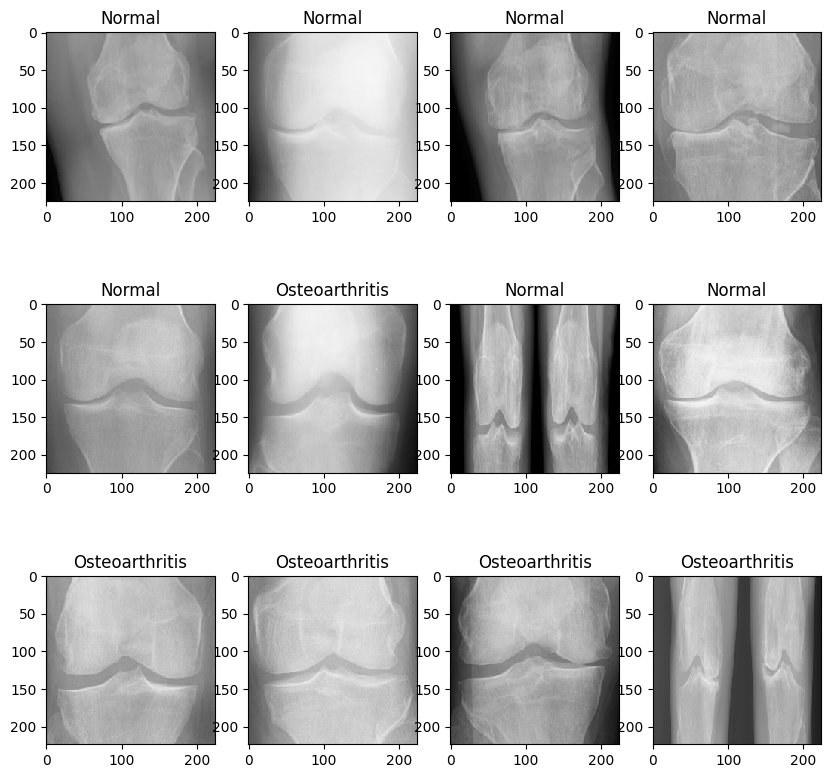

In [ ]:
# # Display first 15 images of moles, and how they are classified
# # Here IDC (+) means Benign
# # IDC (-) means Malignant
w=60
h=40
fig=plt.figure(figsize=(10, 10))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Normal')
    else:
        ax.title.set_text('Osteoarthritis')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [ ]:
BATCH_SIZE = 32

# Using original generator
train_generator = ImageDataGenerator(
        # zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        shear_range = 0.5,
        width_shift_range=0.4,
        height_shift_range=0.4,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True  # randomly flip images
    )

In [ ]:
IMAGE_SIZE=224
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)

# dennet   = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)(inputs)
# nas      = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)(inputs)
vgg      = tf.keras.applications.NASNetMobile(include_top=False, input_shape=input_shape)(inputs)

19993432/19993432 [==============================] - 0s 0us/step


In [ ]:
outputs = GlobalAveragePooling2D()(vgg)
# Concatenate(axis=-1)([GlobalAveragePooling2D()(vgg), GlobalAveragePooling2D()(nas)])
# outputs = Dropout(0.4)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(32,activation='relu')(outputs)
# outputs = Dropout(0.2)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(2, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(lr=0.0001, decay=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 NASNet (Functional)         (None, 7, 7, 1056)        4269716   
                                                                 
 global_average_pooling2d (  (None, 1056)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 1056)              4224      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 32)                33824     
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128   

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/My Driveweights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=40,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

<ipython-input-16-9d9ad6683064>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/40
75/74 [==============================] - ETA: 0s - loss: 0.6093 - accuracy: 0.7069

74/74 [==============================] - 79s 599ms/step - loss: 0.6093 - accuracy: 0.7069 - val_loss: 0.7899 - val_accuracy: 0.6294 - lr: 1.0000e-04
Epoch 2/40
75/74 [==============================] - ETA: 0s - loss: 0.4569 - accuracy: 0.8156

74/74 [==============================] - 40s 530ms/step - loss: 0.4569 - accuracy: 0.8156 - val_loss: 0.6955 - val_accuracy: 0.6260 - lr: 1.0000e-04
Epoch 3/40
75/74 [==============================] - ETA: 0s - loss: 0.3834 - accuracy: 0.8583

74/74 [==============================] - 41s 552ms/step - loss: 0.3834 - accuracy: 0.8583 - val_loss: 0.7667 - val_accuracy: 0.6311 - lr: 1.0000e-04
Epoch 4/40
75/74 [==============================] - ETA: 0s - loss: 0.3647 - accuracy: 0.8737

74/74 [==============================] - 40s 541ms/step - loss: 0.3647 - accuracy: 0.8737 - val_loss: 0.8041 - val_accuracy: 0.6344 - lr: 1.0000e-04
Epoch 5/40
75/74 [==============================] - ETA: 0s - loss: 0.3184 - accuracy: 0.8871

74/74 [==============================] - 39s 522ms/step - loss: 0.3184 - accuracy: 0.8871 - val_loss: 0.8521 - val_accuracy: 0.6327 - lr: 1.0000e-04
Epoch 6/40
75/74 [==============================] - ETA: 0s - loss: 0.3003 - accuracy: 0.8921

74/74 [==============================] - 38s 504ms/step - loss: 0.3003 - accuracy: 0.8921 - val_loss: 0.8201 - val_accuracy: 0.6311 - lr: 1.0000e-04
Epoch 7/40
75/74 [==============================] - ETA: 0s - loss: 0.2859 - accuracy: 0.9051

74/74 [==============================] - 38s 503ms/step - loss: 0.2859 - accuracy: 0.9051 - val_loss: 0.9167 - val_accuracy: 0.6311 - lr: 1.0000e-04
Epoch 8/40
75/74 [==============================] - ETA: 0s - loss: 0.2859 - accuracy: 0.8955

74/74 [==============================] - 40s 527ms/step - loss: 0.2859 - accuracy: 0.8955 - val_loss: 0.9048 - val_accuracy: 0.6444 - lr: 1.0000e-04
Epoch 9/40
75/74 [==============================] - ETA: 0s - loss: 0.2683 - accuracy: 0.9084

74/74 [==============================] - 40s 530ms/step - loss: 0.2683 - accuracy: 0.9084 - val_loss: 0.8117 - val_accuracy: 0.6578 - lr: 1.0000e-04
Epoch 10/40
75/74 [==============================] - ETA: 0s - loss: 0.2564 - accuracy: 0.9055

74/74 [==============================] - 39s 523ms/step - loss: 0.2564 - accuracy: 0.9055 - val_loss: 0.6642 - val_accuracy: 0.6878 - lr: 1.0000e-04
Epoch 11/40
75/74 [==============================] - ETA: 0s - loss: 0.2326 - accuracy: 0.9239

74/74 [==============================] - 40s 528ms/step - loss: 0.2326 - accuracy: 0.9239 - val_loss: 0.6151 - val_accuracy: 0.7045 - lr: 1.0000e-04
Epoch 12/40
75/74 [==============================] - ETA: 0s - loss: 0.2256 - accuracy: 0.9202

74/74 [==============================] - 37s 498ms/step - loss: 0.2256 - accuracy: 0.9202 - val_loss: 0.6142 - val_accuracy: 0.7062 - lr: 1.0000e-04
Epoch 13/40
75/74 [==============================] - ETA: 0s - loss: 0.2237 - accuracy: 0.9227

74/74 [==============================] - 38s 501ms/step - loss: 0.2237 - accuracy: 0.9227 - val_loss: 0.6268 - val_accuracy: 0.6945 - lr: 1.0000e-04
Epoch 14/40
75/74 [==============================] - ETA: 0s - loss: 0.2211 - accuracy: 0.9231

74/74 [==============================] - 39s 521ms/step - loss: 0.2211 - accuracy: 0.9231 - val_loss: 0.5848 - val_accuracy: 0.7179 - lr: 1.0000e-04
Epoch 15/40
75/74 [==============================] - ETA: 0s - loss: 0.2006 - accuracy: 0.9319

74/74 [==============================] - 39s 524ms/step - loss: 0.2006 - accuracy: 0.9319 - val_loss: 0.5433 - val_accuracy: 0.7479 - lr: 1.0000e-04
Epoch 16/40
75/74 [==============================] - ETA: 0s - loss: 0.2028 - accuracy: 0.9314

74/74 [==============================] - 38s 507ms/step - loss: 0.2028 - accuracy: 0.9314 - val_loss: 0.4986 - val_accuracy: 0.7696 - lr: 1.0000e-04
Epoch 17/40
75/74 [==============================] - ETA: 0s - loss: 0.2054 - accuracy: 0.9273

74/74 [==============================] - 38s 500ms/step - loss: 0.2054 - accuracy: 0.9273 - val_loss: 0.4250 - val_accuracy: 0.8164 - lr: 1.0000e-04
Epoch 18/40
75/74 [==============================] - ETA: 0s - loss: 0.2071 - accuracy: 0.9206

74/74 [==============================] - 39s 520ms/step - loss: 0.2071 - accuracy: 0.9206 - val_loss: 0.4320 - val_accuracy: 0.8197 - lr: 1.0000e-04
Epoch 19/40
75/74 [==============================] - ETA: 0s - loss: 0.1831 - accuracy: 0.9339

74/74 [==============================] - 39s 525ms/step - loss: 0.1831 - accuracy: 0.9339 - val_loss: 0.4286 - val_accuracy: 0.8197 - lr: 1.0000e-04
Epoch 20/40
75/74 [==============================] - ETA: 0s - loss: 0.1789 - accuracy: 0.9390

74/74 [==============================] - 39s 522ms/step - loss: 0.1789 - accuracy: 0.9390 - val_loss: 0.3508 - val_accuracy: 0.8381 - lr: 1.0000e-04
Epoch 21/40
75/74 [==============================] - ETA: 0s - loss: 0.1953 - accuracy: 0.9314

74/74 [==============================] - 39s 515ms/step - loss: 0.1953 - accuracy: 0.9314 - val_loss: 0.2952 - val_accuracy: 0.8932 - lr: 1.0000e-04
Epoch 22/40
75/74 [==============================] - ETA: 0s - loss: 0.2023 - accuracy: 0.9293

74/74 [==============================] - 38s 504ms/step - loss: 0.2023 - accuracy: 0.9293 - val_loss: 0.2695 - val_accuracy: 0.9165 - lr: 1.0000e-04
Epoch 23/40
75/74 [==============================] - ETA: 0s - loss: 0.1784 - accuracy: 0.9344

74/74 [==============================] - 40s 531ms/step - loss: 0.1784 - accuracy: 0.9344 - val_loss: 0.2646 - val_accuracy: 0.9098 - lr: 1.0000e-04
Epoch 24/40
75/74 [==============================] - ETA: 0s - loss: 0.1642 - accuracy: 0.9394

74/74 [==============================] - 39s 524ms/step - loss: 0.1642 - accuracy: 0.9394 - val_loss: 0.2425 - val_accuracy: 0.9199 - lr: 1.0000e-04
Epoch 25/40
75/74 [==============================] - ETA: 0s - loss: 0.1729 - accuracy: 0.9369

74/74 [==============================] - 38s 508ms/step - loss: 0.1729 - accuracy: 0.9369 - val_loss: 0.2436 - val_accuracy: 0.9165 - lr: 1.0000e-04
Epoch 26/40
75/74 [==============================] - ETA: 0s - loss: 0.1631 - accuracy: 0.9415

74/74 [==============================] - 39s 509ms/step - loss: 0.1631 - accuracy: 0.9415 - val_loss: 0.2495 - val_accuracy: 0.9232 - lr: 1.0000e-04
Epoch 27/40
75/74 [==============================] - ETA: 0s - loss: 0.1483 - accuracy: 0.9406

74/74 [==============================] - 39s 513ms/step - loss: 0.1483 - accuracy: 0.9406 - val_loss: 0.2542 - val_accuracy: 0.9165 - lr: 1.0000e-04
Epoch 28/40
75/74 [==============================] - ETA: 0s - loss: 0.1687 - accuracy: 0.9369

74/74 [==============================] - 40s 532ms/step - loss: 0.1687 - accuracy: 0.9369 - val_loss: 0.2141 - val_accuracy: 0.9299 - lr: 1.0000e-04
Epoch 29/40
75/74 [==============================] - ETA: 0s - loss: 0.1530 - accuracy: 0.9431

74/74 [==============================] - 40s 528ms/step - loss: 0.1530 - accuracy: 0.9431 - val_loss: 0.2487 - val_accuracy: 0.9115 - lr: 1.0000e-04
Epoch 30/40
75/74 [==============================] - ETA: 0s - loss: 0.1299 - accuracy: 0.9544

74/74 [==============================] - 40s 528ms/step - loss: 0.1299 - accuracy: 0.9544 - val_loss: 0.2712 - val_accuracy: 0.9065 - lr: 1.0000e-04
Epoch 31/40
75/74 [==============================] - ETA: 0s - loss: 0.1506 - accuracy: 0.9477

74/74 [==============================] - 38s 506ms/step - loss: 0.1506 - accuracy: 0.9477 - val_loss: 0.2413 - val_accuracy: 0.9199 - lr: 1.0000e-04
Epoch 32/40
75/74 [==============================] - ETA: 0s - loss: 0.1454 - accuracy: 0.9452

74/74 [==============================] - 37s 499ms/step - loss: 0.1454 - accuracy: 0.9452 - val_loss: 0.2880 - val_accuracy: 0.9165 - lr: 1.0000e-04
Epoch 33/40
75/74 [==============================] - ETA: 0s - loss: 0.1455 - accuracy: 0.9473

74/74 [==============================] - 38s 505ms/step - loss: 0.1455 - accuracy: 0.9473 - val_loss: 0.1903 - val_accuracy: 0.9399 - lr: 1.0000e-04
Epoch 34/40
75/74 [==============================] - ETA: 0s - loss: 0.1470 - accuracy: 0.9507

74/74 [==============================] - 38s 504ms/step - loss: 0.1470 - accuracy: 0.9507 - val_loss: 0.3035 - val_accuracy: 0.9065 - lr: 1.0000e-04
Epoch 35/40
75/74 [==============================] - ETA: 0s - loss: 0.1381 - accuracy: 0.9498

74/74 [==============================] - 39s 523ms/step - loss: 0.1381 - accuracy: 0.9498 - val_loss: 0.2262 - val_accuracy: 0.9265 - lr: 1.0000e-04
Epoch 36/40
75/74 [==============================] - ETA: 0s - loss: 0.1377 - accuracy: 0.9540

74/74 [==============================] - 40s 533ms/step - loss: 0.1377 - accuracy: 0.9540 - val_loss: 0.2021 - val_accuracy: 0.9265 - lr: 1.0000e-04
Epoch 37/40
75/74 [==============================] - ETA: 0s - loss: 0.1424 - accuracy: 0.9427

74/74 [==============================] - 40s 529ms/step - loss: 0.1424 - accuracy: 0.9427 - val_loss: 0.2356 - val_accuracy: 0.9282 - lr: 1.0000e-04
Epoch 38/40
75/74 [==============================] - ETA: 0s - loss: 0.1358 - accuracy: 0.9452

74/74 [==============================] - 37s 499ms/step - loss: 0.1358 - accuracy: 0.9452 - val_loss: 0.2000 - val_accuracy: 0.9399 - lr: 1.0000e-04
Epoch 39/40
75/74 [==============================] - ETA: 0s - loss: 0.1323 - accuracy: 0.9473

74/74 [==============================] - 39s 511ms/step - loss: 0.1323 - accuracy: 0.9473 - val_loss: 0.1951 - val_accuracy: 0.9449 - lr: 1.0000e-04
Epoch 40/40
75/74 [==============================] - ETA: 0s - loss: 0.1239 - accuracy: 0.9532

74/74 [==============================] - 39s 519ms/step - loss: 0.1239 - accuracy: 0.9532 - val_loss: 0.1607 - val_accuracy: 0.9516 - lr: 1.0000e-04


19/19 [==============================] - 6s 83ms/step
Confusion matrix, without normalization
[[213  10]
 [ 19 357]]


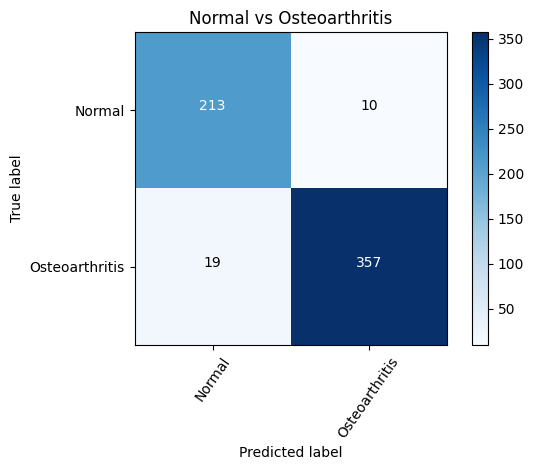

In [ ]:
Y_pred = model.predict(x_val)
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['Normal', 'Osteoarthritis']
plot_confusion_matrix(cm, cm_plot_label, title ='Normal vs Osteoarthritis')

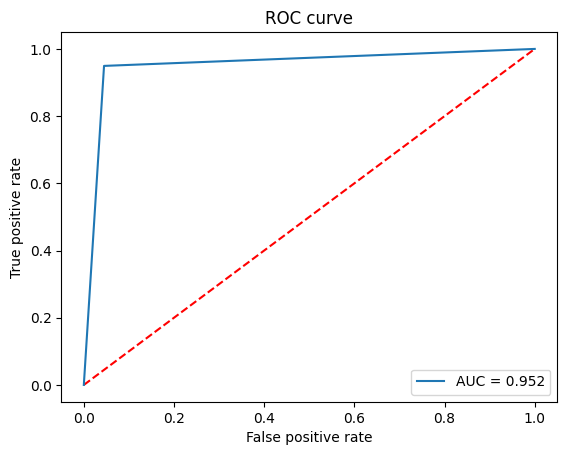

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(y_val, axis=1), np.argmax(Y_pred, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(y_val, axis=1), np.argmax(Y_pred, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

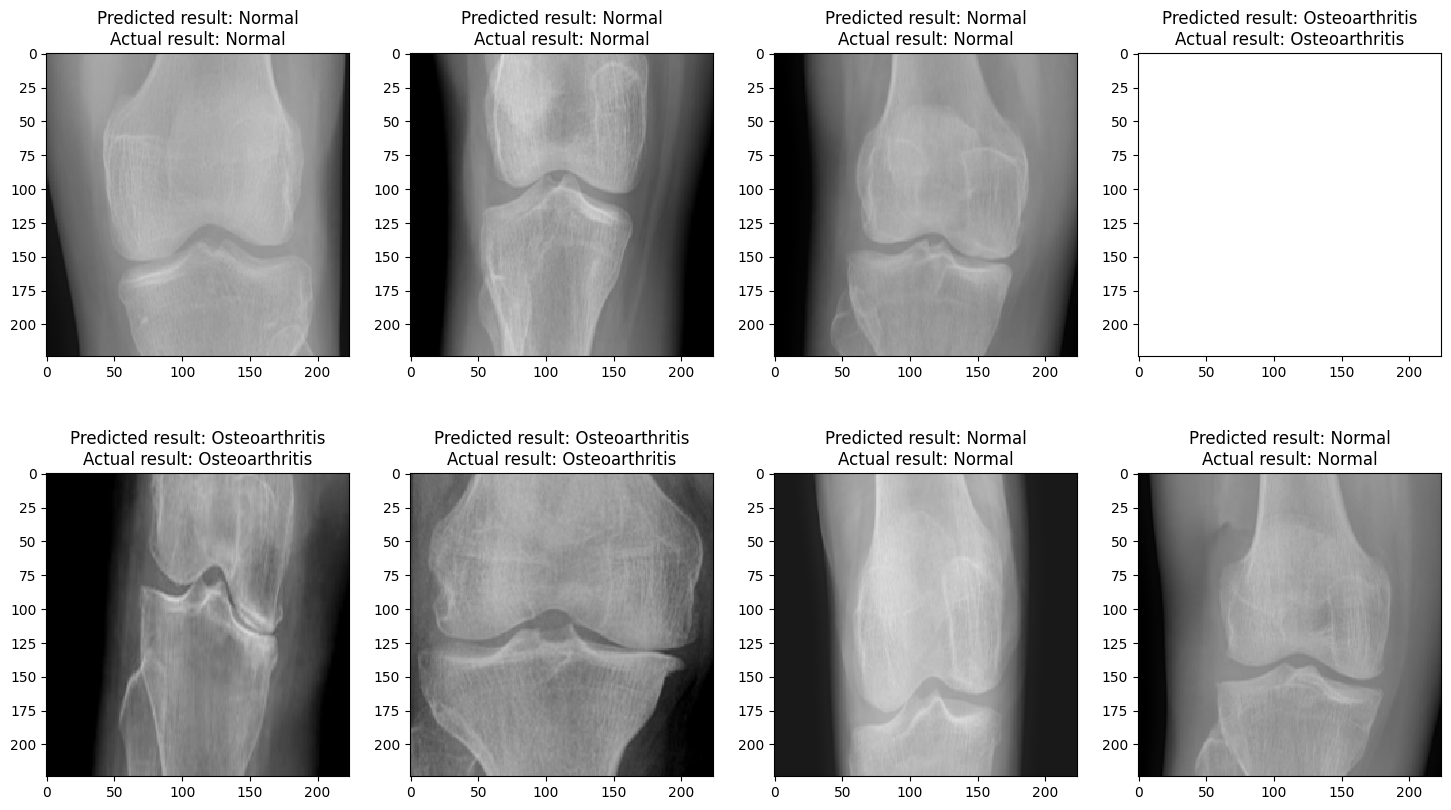

In [ ]:

i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Normal"
    else:
        return "Osteoarthritis"

for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result: "+ Transfername(np.argmax(Y_pred[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()

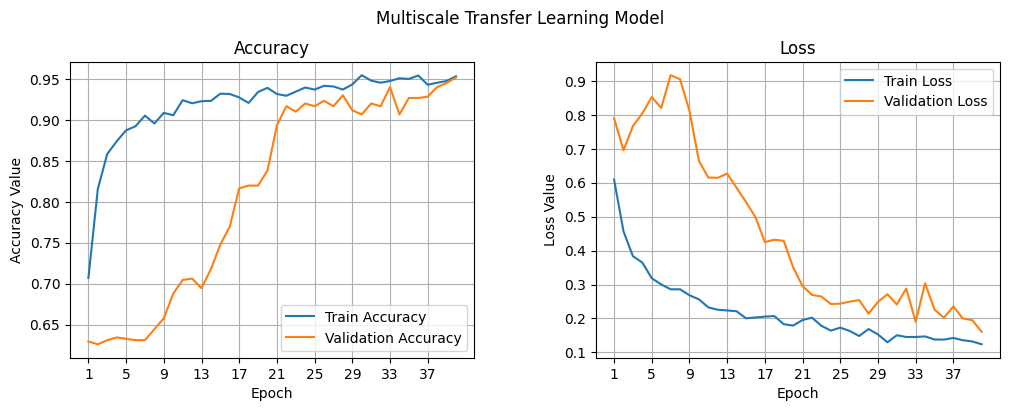

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Multiscale Transfer Learning Model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,41))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 41, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 41, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

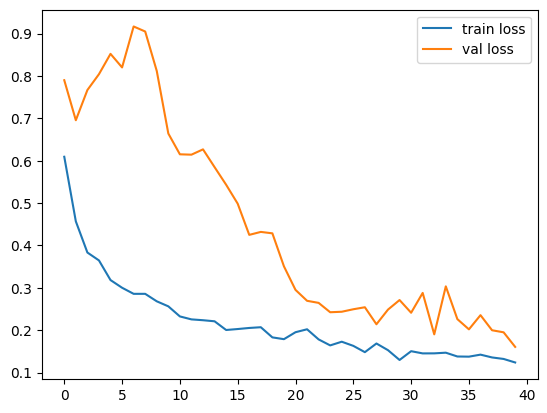

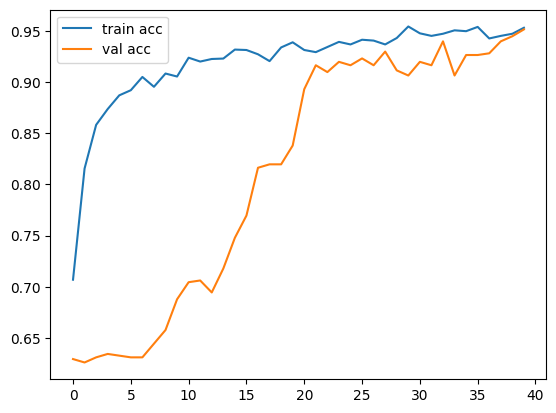

In [ ]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [ ]:
pred=model.predict(x_val)
Y_pred = np.argmax(pred, 1)
y_test=np.argmax(y_val,1)

19/19 [==============================] - 1s 64ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
target_names = ['Osteoarthritis', 'Normal']
print(classification_report(y_test, Y_pred, target_names=target_names))

Classification Report
                precision    recall  f1-score   support

Osteoarthritis       0.92      0.96      0.94       223
        Normal       0.97      0.95      0.96       376

      accuracy                           0.95       599
     macro avg       0.95      0.95      0.95       599
  weighted avg       0.95      0.95      0.95       599

